In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    average_precision_score
)

C:\Users\Dell\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
path = rf'data/npa_dataset.csv'
#https://www.kaggle.com/datasets/darshandalvi12/non-performing-assets-npa/code?datasetId=6509020
data=pd.read_csv(path)
pd.set_option('display.float_format', '{:.5f}'.format)
print(data.columns)
print(data['Loan_Type'].value_counts(normalize=True))

Index(['Loan_ID', 'Customer_ID', 'Loan_Amount', 'Loan_Type', 'Credit_Score',
       'Repayment_History', 'Collateral_Value', 'Loan_Tenure',
       'Default_Status'],
      dtype='object')
Loan_Type
Business    0.20069
Education   0.20063
Vehicle     0.20003
Personal    0.19938
Home        0.19927
Name: proportion, dtype: float64


In [3]:
data['Loan_Amount_per_Month'] = data['Loan_Amount']/data['Loan_Tenure']
# EMI scale.

data['Collateral_Coverage'] = data['Collateral_Value']/data['Loan_Amount']
# Values < 1 → higher default risk
data.describe()

,Loan_Amount,Credit_Score,Repayment_History,Collateral_Value,Loan_Tenure,Default_Status,Loan_Amount_per_Month,Collateral_Coverage
count,300221.00000,300221.00000,300221.00000,300221.00000,300221.00000,300221.00000,300221.00000,300221.00000
mean,2530722.09042,575.28275,75.03148,1992231.94261,185.53565,0.27093,25010.67155,1.85827
std,1427793.95051,159.16789,14.44840,1153038.29692,100.43136,0.44444,37574.37506,4.26913
min,50004.00000,300.00000,50.00004,18.00000,12.00000,0.00000,139.59331,0.00001
25%,1294031.00000,437.00000,62.48952,993524.00000,99.00000,0.00000,6984.43874,0.39245
50%,2535654.00000,575.00000,75.05208,1988123.00000,185.00000,0.00000,13652.37959,0.78760
75%,3767650.00000,713.00000,87.55599,2988275.00000,272.00000,1.00000,25730.48701,1.53786
max,4999999.00000,850.00000,99.99964,3999995.00000,359.00000,1.00000,416482.58333,77.41383


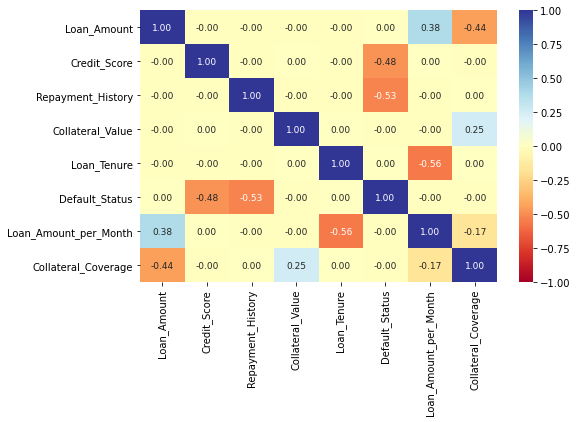

In [4]:
plt.figure(figsize=(8, 5))   # smaller size
sns.heatmap(data.corr(numeric_only=True), cmap="RdYlBu", annot=True,annot_kws={"size": 9},fmt=".2f",vmin = -1, vmax = 1)
plt.show()

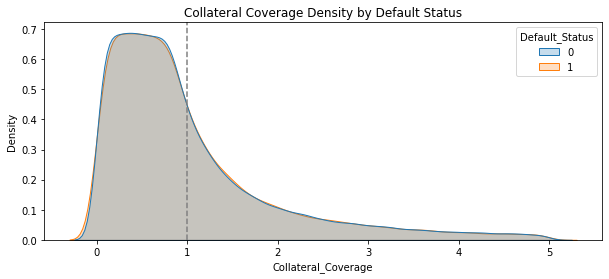

In [5]:
default_rate = data.groupby("Loan_Type")["Default_Status"].sum().sort_values()
default_rate
plt.figure(figsize=(10,4))
filtered = data[data["Collateral_Coverage"] < 5]
sns.kdeplot(data=filtered, x="Collateral_Coverage", hue="Default_Status", fill=True, common_norm=False)
plt.axvline(1, color='gray', linestyle='--')
plt.title("Collateral Coverage Density by Default Status")
plt.show()

In [6]:
data.groupby("Default_Status")["Collateral_Coverage"].describe()

## This shows the Collateral Coverage is not the driving force for the data

,count,mean,std,min,25%,50%,75%,max
Default_Status,,,,,,,,
0,218883.00000,1.86178,4.27150,0.00001,0.39240,0.78787,1.54000,77.41383
1,81338.00000,1.84884,4.26278,0.00005,0.39281,0.78697,1.53071,76.88528


In [7]:
#One-Hot Encoding- Loan Type
dummies = pd.get_dummies(data['Loan_Type'], prefix='LoanType').astype(int)
data = pd.concat([data, dummies], axis=1)
data.drop(columns=['Loan_Type'], inplace=True)
data

,Loan_ID,Customer_ID,Loan_Amount,Credit_Score,Repayment_History,Collateral_Value,Loan_Tenure,Default_Status,Loan_Amount_per_Month,Collateral_Coverage,LoanType_Business,LoanType_Education,LoanType_Home,LoanType_Personal,LoanType_Vehicle
0,L00001,C00001,1742743,505,68.02955,481766,88,1,19803.89773,0.27644,0,0,0,1,0
1,L00002,C00002,4354572,654,66.63517,2912934,33,0,131956.72727,0.66894,1,0,0,0,0
2,L00003,C00003,4976484,330,55.71254,1347431,217,1,22933.10599,0.27076,0,0,0,0,1
3,L00004,C00004,2284489,543,70.50444,2808402,205,1,11143.84878,1.22933,0,0,0,0,1
4,L00005,C00005,1620006,788,80.25426,680588,73,0,22191.86301,0.42011,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300216,L300217,C300217,4976007,737,70.22034,2357776,145,0,34317.28966,0.47383,0,0,0,1,0
300217,L300218,C300218,4204415,542,81.31633,170435,272,0,15457.40809,0.04054,0,1,0,0,0
300218,L300219,C300219,1636919,764,60.21526,3434251,197,0,8309.23350,2.09800,0,0,0,1,0
300219,L300220,C300220,225792,733,97.03474,828468,39,0,5789.53846,3.66916,0,1,0,0,0


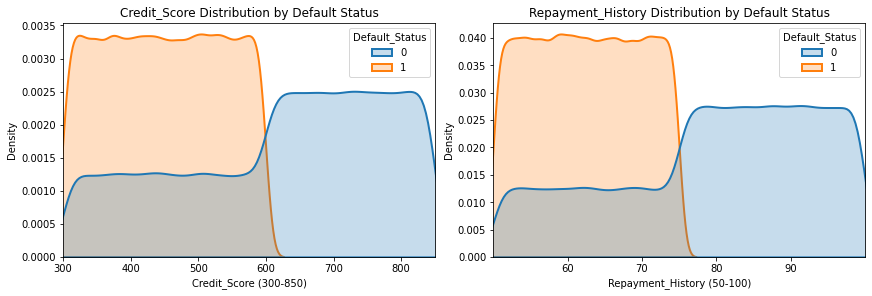

In [8]:
cols = ["Credit_Score", "Repayment_History"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

for ax, col in zip(axes, cols):

    xmin = data[col].min()
    xmax = data[col].max()

    sns.kdeplot(data=data[(data[col] >= xmin) & (data[col] <= xmax)],
        x=col, hue="Default_Status",fill=True, common_norm=False, linewidth=2,ax=ax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(f"{col} ({xmin:.0f}-{xmax:.0f})")
    ax.set_title(f"{col} Distribution by Default Status")

plt.show()

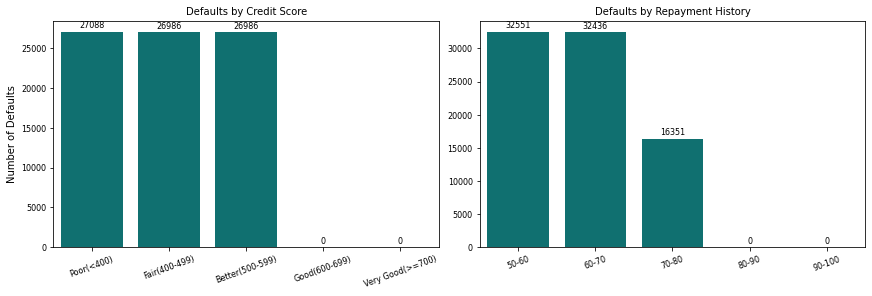

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

configs = [
    # src_col,          bins,                           labels,           
    ("Credit_Score",      [300, 400, 500, 600, 700, 800], ["Poor(<400)", "Fair(400-499)", "Better(500-599)", "Good(600-699)", "Very Good(>=700)"],  "Defaults by Credit Score"),
    ("Repayment_History", [50, 60, 70, 80, 90, 100],      ["50-60", "60-70", "70-80", "80-90", "90-100"],                               "Defaults by Repayment History"),
]

for ax, (src_col, bins, labels, title) in zip(axes, configs):

    # temporary bins (not stored in data)
    bucket = pd.cut(data[src_col], bins=bins, labels=labels)

    tmp = (data.groupby(bucket)["Default_Status"].sum().reset_index(name="Default_Count"))

    sns.barplot(data=tmp, x=bucket.name, y="Default_Count", ax=ax,color='teal')
    ax.bar_label(ax.containers[0], fmt='%d', padding=2, fontsize=8)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("Number of Defaults" if "Credit" in title else "")
    ax.tick_params(axis="x", rotation=20, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

plt.show()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300221 entries, 0 to 300220
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Loan_ID                300221 non-null  object 
 1   Customer_ID            300221 non-null  object 
 2   Loan_Amount            300221 non-null  int64  
 3   Credit_Score           300221 non-null  int64  
 4   Repayment_History      300221 non-null  float64
 5   Collateral_Value       300221 non-null  int64  
 6   Loan_Tenure            300221 non-null  int64  
 7   Default_Status         300221 non-null  int64  
 8   Loan_Amount_per_Month  300221 non-null  float64
 9   Collateral_Coverage    300221 non-null  float64
 10  LoanType_Business      300221 non-null  int32  
 11  LoanType_Education     300221 non-null  int32  
 12  LoanType_Home          300221 non-null  int32  
 13  LoanType_Personal      300221 non-null  int32  
 14  LoanType_Vehicle       300221 non-nu

In [12]:
#Feature importance 
X = data.drop(columns=["Default_Status","Loan_ID","Customer_ID"])
y = data["Default_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    suffix = model_name.lower().replace(" ", "_")

    model.fit(X_train, y_train)

    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train = model.predict_proba(X_train)[:, 1]

    test_auc = roc_auc_score(y_test, y_prob_test)
    pr_auc = average_precision_score(y_test, y_prob_test)
    train_auc = roc_auc_score(y_train, y_prob_train)

    print(f"\n{model_name}")
    print(f"Test ROC - AUC score is: {test_auc:.3f}")
    print(f"Average Precision PR - AUC score is: {pr_auc:.3f}")
    print(f"Train AUC ({model_name}): {train_auc:.3f}")

    # Target shuffle test
    y_shuffled = y_train.sample(frac=1, random_state=42)
    model.fit(X_train, y_shuffled)
    shuffled_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"AUC after shuffling target: {shuffled_auc:.3f}")

    # Confusion matrix
    threshold = 0.3
    y_pred = (y_prob_test >= threshold).astype(int)
    print(confusion_matrix(y_test, y_pred))

    return {
        f"y_prob_{suffix}": y_prob_test,
        f"test_auc_{suffix}": test_auc,
        f"pr_auc_{suffix}": pr_auc,
        f"train_auc_{suffix}": train_auc,
        f"shuffled_auc_{suffix}": shuffled_auc
    }

In [14]:
# Logistic Regression
log = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_metrics = evaluate_model(log, X_train, X_test, y_train, y_test, "Logistic")

# Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=8, class_weight="balanced", random_state=42)
rf_metrics = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

# XGBoost
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
ratio = neg / pos
xgb = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05, scale_pos_weight=ratio, eval_metric="auc", random_state=42)
xgb_metrics = evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")
metrics = {"Logistic": log_metrics, "Random Forest": rf_metrics, "XGBoost": xgb_metrics}
comparison_df = (pd.DataFrame({
        model: {k.replace(f"_{model.lower().replace(' ', '_')}", ""): v
            for k, v in m.items()
            if "auc_" in k}
        for model, m in {"Logistic": log_metrics, "Random Forest": rf_metrics, "XGBoost": xgb_metrics}.items()})
    .rename(columns={"test_auc": "Test ROC-AUC", "pr_auc": "PR-AUC", "train_auc": "Train ROC-AUC", "shuffled_auc": "Shuffled ROC-AUC"}).round(3))

comparison_df


Logistic
Test ROC - AUC score is: 0.737
Average Precision PR - AUC score is: 0.450
Train AUC (Logistic): 0.741
AUC after shuffling target: 0.499
[[17882 25895]
 [ 1530 14738]]

Random Forest
Test ROC - AUC score is: 1.000
Average Precision PR - AUC score is: 1.000
Train AUC (Random Forest): 1.000
AUC after shuffling target: 0.563
[[43777     0]
 [    0 16268]]

XGBoost
Test ROC - AUC score is: 1.000
Average Precision PR - AUC score is: 1.000
Train AUC (XGBoost): 1.000
AUC after shuffling target: 0.546
[[43681    96]
 [    0 16268]]


,Logistic,Random Forest,XGBoost
test_auc,0.73700,1.00000,1.00000
pr_auc,0.45000,1.00000,1.00000
train_auc,0.74100,1.00000,1.00000
shuffled_auc,0.49900,0.56300,0.54600


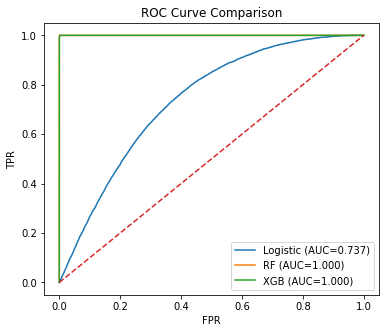

In [17]:
#check number of iterations
#log.n_iter_
#If train >> test : overfitting
# High ROC–AUC dropped using a target shuffle test to ~0.45, ~0.56, ~0.55, indicating no data leakage.
#AP numbers are always smaller than ROC-AUC. High ROC-AUC + low AP = model ranks well but is operationally noisy.
#ROC-AUC measures how well the model separates defaulters from non-defaulters independent of thresholds, 
#Average Precision focuses on the quality of high-risk predictions and is more informative under class imbalance. For loan default, evaluate both.”
fpr_l, tpr_l, _ = roc_curve(y_test, log_metrics["y_prob_logistic"])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_metrics["y_prob_random_forest"])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_metrics["y_prob_xgboost"])

plt.figure(figsize=(6,5))
plt.plot(fpr_l, tpr_l, label=f"Logistic (AUC={log_metrics['test_auc_logistic']:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={rf_metrics['test_auc_random_forest']:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={xgb_metrics['test_auc_xgboost']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [18]:
# Check data - leakage
coef_l = pd.DataFrame({"feature": X_train.columns,"coefficient": log.coef_[0]}).sort_values("coefficient")
imp_rf = pd.DataFrame({"feature": X_train.columns,"importance": rf.feature_importances_}).sort_values("importance")
print(coef_l)
print(imp_rf)

                  feature  coefficient
5   Loan_Amount_per_Month     -0.00000
3        Collateral_Value     -0.00000
2       Repayment_History     -0.00000
4             Loan_Tenure     -0.00000
6     Collateral_Coverage     -0.00000
11       LoanType_Vehicle     -0.00000
10      LoanType_Personal     -0.00000
7       LoanType_Business     -0.00000
8      LoanType_Education      0.00000
9           LoanType_Home      0.00000
1            Credit_Score      0.00000
0             Loan_Amount      0.00000
                  feature  importance
9           LoanType_Home     0.00889
7       LoanType_Business     0.00949
8      LoanType_Education     0.01002
10      LoanType_Personal     0.01011
11       LoanType_Vehicle     0.01045
4             Loan_Tenure     0.10649
1            Credit_Score     0.11298
6     Collateral_Coverage     0.13895
3        Collateral_Value     0.14294
5   Loan_Amount_per_Month     0.14787
0             Loan_Amount     0.14994
2       Repayment_History     0.15188

In [19]:
#While tree-based models showed perfect performance, validation using shuffle tests and confusion matrices indicated data leakage. 
#The logistic regression model provided stable and realistic performance and served as the reliable baseline.
leaky = ["Repayment_History"]

X_train_clean = X_train.drop(columns=leaky)
X_test_clean  = X_test.drop(columns=leaky)

In [20]:
# Logistic Regression
log = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
logclean_metrics = evaluate_model(log, X_train_clean, X_test_clean, y_train, y_test, "Logistic")

# Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=8, class_weight="balanced", random_state=42)
rfclean_metrics = evaluate_model(rf, X_train_clean, X_test_clean, y_train, y_test, "Random Forest")

# XGBoost
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
ratio = neg / pos
xgb = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05, scale_pos_weight=ratio, eval_metric="auc", random_state=42)
xgbclean_metrics = evaluate_model(xgb, X_train_clean, X_test_clean, y_train, y_test, "XGBoost")
metrics = {"Logistic": logclean_metrics, "Random Forest": rfclean_metrics, "XGBoost": xgbclean_metrics}
comparison_df = (pd.DataFrame({
        model: {k.replace(f"_{model.lower().replace(' ', '_')}", ""): v
            for k, v in m.items()
            if "auc_" in k}
        for model, m in {"Logistic": logclean_metrics, "Random Forest": rfclean_metrics, "XGBoost": xgbclean_metrics}.items()})
    .rename(columns={"test_auc": "Test ROC-AUC", "pr_auc": "PR-AUC", "train_auc": "Train ROC-AUC", "shuffled_auc": "Shuffled ROC-AUC"}).round(3))

comparison_df


Logistic
Test ROC - AUC score is: 0.703
Average Precision PR - AUC score is: 0.426
Train AUC (Logistic): 0.706
AUC after shuffling target: 0.499
[[14394 29383]
 [ 1404 14864]]

Random Forest
Test ROC - AUC score is: 0.813
Average Precision PR - AUC score is: 0.499
Train AUC (Random Forest): 0.846
AUC after shuffling target: 0.492
[[27271 16506]
 [    0 16268]]

XGBoost
Test ROC - AUC score is: 0.810
Average Precision PR - AUC score is: 0.492
Train AUC (XGBoost): 0.837
AUC after shuffling target: 0.500
[[27176 16601]
 [    1 16267]]


,Logistic,Random Forest,XGBoost
test_auc,0.70300,0.81300,0.81000
pr_auc,0.42600,0.49900,0.49200
train_auc,0.70600,0.84600,0.83700
shuffled_auc,0.49900,0.49200,0.50000


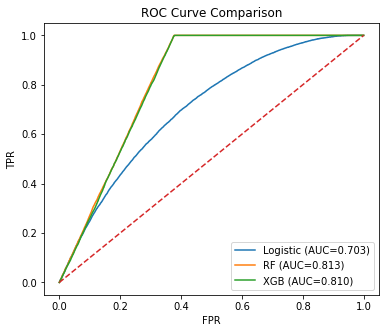

In [21]:
fpr_l, tpr_l, _ = roc_curve(y_test, logclean_metrics["y_prob_logistic"])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rfclean_metrics["y_prob_random_forest"])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgbclean_metrics["y_prob_xgboost"])

plt.figure(figsize=(6,5))
plt.plot(fpr_l, tpr_l, label=f"Logistic (AUC={logclean_metrics['test_auc_logistic']:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={rfclean_metrics['test_auc_random_forest']:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={xgbclean_metrics['test_auc_xgboost']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [22]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
